Group 1

Course: CIS 9665 Applied Natural Language Processing - Spring 2024

Final Project: Analyzing 2010-2017 Amazon Fire Tablet Reviews

Data found on: https://www.kaggle.com/datasets/datafiniti/consumer-reviews-of-amazon-products/data

In [2]:
# Importing necessary packages for analysis
import numpy as np
import pandas as pd
import random
import math

import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import pos_tag
from nltk import FreqDist

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report
import statsmodels.api as sm

import matplotlib.pyplot as plt

In [3]:
# Reading information from the 3 separate CSVs into their own dataframes
df1 = pd.read_csv("1429_1.csv",low_memory=False)
df2 = pd.read_csv("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")
df3 = pd.read_csv("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")

# Data Cleaning

In [4]:
# Merging 3 datasets into 1 dataframe and only keeping 3 columns: "name", "reviews.doRecommend" and "reviews.text"
dflist = [df1, df2, df3]
alldf = pd.concat(dflist, ignore_index=True)
alldf = alldf[['name', 'reviews.doRecommend', 'reviews.text']]

In [5]:
# Covert columns to string
alldf["name"] = alldf["name"].astype(str)
alldf["reviews.text"] = alldf["reviews.text"].astype(str)
alldf["reviews.doRecommend"] = alldf["reviews.doRecommend"].astype(str)

In [6]:
# Using only the words before the first comma as product name
alldf['name'] = alldf['name'].str.split(',', expand=True)[0]
alldf

,name,reviews.doRecommend,reviews.text
0,All-New Fire HD 8 Tablet,True,This product so far has not disappointed. My c...
1,All-New Fire HD 8 Tablet,True,great for beginner or experienced person. Boug...
2,All-New Fire HD 8 Tablet,True,Inexpensive tablet for him to use and learn on...
3,All-New Fire HD 8 Tablet,True,I've had my Fire HD 8 two weeks now and I love...
4,All-New Fire HD 8 Tablet,True,I bought this for my grand daughter when she c...
...,...,...,...
67987,Fire Tablet with Alexa,True,This is a great tablet for the price. Amazon i...
67988,Fire Tablet with Alexa,True,This tablet is the perfect size and so easy to...
67989,Fire Tablet with Alexa,True,Purchased this for my son. Has room to upgrade...
67990,Fire Tablet with Alexa,True,I had some thoughts about getting this for a 5...


In [7]:
# Converting reviews.doRecommend column to 1, 0, -1
mapping = {'True': 1, 'False': 0, 'nan': -1}
alldf["reviews.doRecommend"] = alldf["reviews.doRecommend"].map(mapping)
alldf.head()

,name,reviews.doRecommend,reviews.text
0,All-New Fire HD 8 Tablet,1,This product so far has not disappointed. My c...
1,All-New Fire HD 8 Tablet,1,great for beginner or experienced person. Boug...
2,All-New Fire HD 8 Tablet,1,Inexpensive tablet for him to use and learn on...
3,All-New Fire HD 8 Tablet,1,I've had my Fire HD 8 two weeks now and I love...
4,All-New Fire HD 8 Tablet,1,I bought this for my grand daughter when she c...


In [8]:
# Clean reviews text by lowercasing and dropping stopwords except "not"/"no"
stopwords = [w for w in nltk.corpus.stopwords.words('english') if w not in ['not', 'no']]
def clean_reviews(text):
    text = text.lower()
    words = nltk.word_tokenize(text)
    words = [w for w in words if w.isalpha() and w not in stopwords]
    clean_text = " ".join(words)
    return clean_text

alldf["review_clean"] = alldf["reviews.text"].apply(lambda x: clean_reviews(x))
alldf.head()

,name,reviews.doRecommend,reviews.text,review_clean
0,All-New Fire HD 8 Tablet,1,This product so far has not disappointed. My c...,product far not disappointed children love use...
1,All-New Fire HD 8 Tablet,1,great for beginner or experienced person. Boug...,great beginner experienced person bought gift ...
2,All-New Fire HD 8 Tablet,1,Inexpensive tablet for him to use and learn on...,inexpensive tablet use learn step nabi thrille...
3,All-New Fire HD 8 Tablet,1,I've had my Fire HD 8 two weeks now and I love...,fire hd two weeks love tablet great prime memb...
4,All-New Fire HD 8 Tablet,1,I bought this for my grand daughter when she c...,bought grand daughter comes visit set user ent...


In [9]:
alldf[["reviews.text", "review_clean"]]

,reviews.text,review_clean
0,This product so far has not disappointed. My c...,product far not disappointed children love use...
1,great for beginner or experienced person. Boug...,great beginner experienced person bought gift ...
2,Inexpensive tablet for him to use and learn on...,inexpensive tablet use learn step nabi thrille...
3,I've had my Fire HD 8 two weeks now and I love...,fire hd two weeks love tablet great prime memb...
4,I bought this for my grand daughter when she c...,bought grand daughter comes visit set user ent...
...,...,...
67987,This is a great tablet for the price. Amazon i...,great tablet price amazon good job
67988,This tablet is the perfect size and so easy to...,tablet perfect size easy use read play games p...
67989,Purchased this for my son. Has room to upgrade...,purchased son room upgrade memory allow books ...
67990,I had some thoughts about getting this for a 5...,thoughts getting year old get screen protector...


In [11]:
# Checking the distribution of the dependent variable
# We remove rows with "nan" as dependent variable
alldf["reviews.doRecommend"].value_counts(normalize = True)

 1    0.776562
-1    0.188846
 0    0.034592
Name: reviews.doRecommend, dtype: float64

In [12]:
# 87 unique products
alldf["name"].nunique()

87

In [13]:
# Finding the product that has the most reviews: Fire Tablet, 12733 reviews
# Thus for the purposes of this project, we will only focus on the Fire Tablet
alldf["name"].value_counts().idxmax()

'Fire Tablet'

In [14]:
alldf[alldf["name"] == "Fire Tablet"].shape[0]

12733

In [16]:
# Creating dataframe only for reviews of 'Fire Tablet' product
firetablet_df = alldf.loc[alldf["name"] == "Fire Tablet"].reset_index(drop=True)
firetablet_df

,name,reviews.doRecommend,reviews.text,review_clean
0,Fire Tablet,1,The sales people are really nice and knowledge...,sales people really nice knowledgeable come back
1,Fire Tablet,1,Great product and service and the sales man r ...,great product service sales man r really nice
2,Fire Tablet,1,Great product and service will refer to a frie...,great product service refer friend sales man r...
3,Fire Tablet,1,very good product and service will refer a fri...,good product service refer friend
4,Fire Tablet,1,Great selections. Hard to find assistance at t...,great selections hard find assistance times
...,...,...,...,...
12728,Fire Tablet,1,We already had a tablet for our son and it was...,already tablet son time get one daughter good ...
12729,Fire Tablet,1,Great upgrade/replacement. No problems with it...,great no problems
12730,Fire Tablet,1,easy to use plenty of space for a kid recommen...,easy use plenty space kid recommend warranty
12731,Fire Tablet,1,Bought as a gift but have not had any issues w...,bought gift not issues products purchased


In [17]:
# Checking the distribution of the dependent variable
firetablet_df["reviews.doRecommend"].value_counts(normalize = True)

 1    0.947538
 0    0.049164
-1    0.003299
Name: reviews.doRecommend, dtype: float64

In [18]:
# Dropping rows with null recommend values
firetablet_df = firetablet_df.loc[firetablet_df["reviews.doRecommend"] != -1].reset_index(drop=True)
firetablet_df

,name,reviews.doRecommend,reviews.text,review_clean
0,Fire Tablet,1,The sales people are really nice and knowledge...,sales people really nice knowledgeable come back
1,Fire Tablet,1,Great product and service and the sales man r ...,great product service sales man r really nice
2,Fire Tablet,1,Great product and service will refer to a frie...,great product service refer friend sales man r...
3,Fire Tablet,1,very good product and service will refer a fri...,good product service refer friend
4,Fire Tablet,1,Great selections. Hard to find assistance at t...,great selections hard find assistance times
...,...,...,...,...
12686,Fire Tablet,1,We already had a tablet for our son and it was...,already tablet son time get one daughter good ...
12687,Fire Tablet,1,Great upgrade/replacement. No problems with it...,great no problems
12688,Fire Tablet,1,easy to use plenty of space for a kid recommen...,easy use plenty space kid recommend warranty
12689,Fire Tablet,1,Bought as a gift but have not had any issues w...,bought gift not issues products purchased


In [19]:
# Dropping rows with empty reviews after cleaning
firetablet_df = firetablet_df[firetablet_df["review_clean"]!=""].reset_index(drop=True)
firetablet_df

,name,reviews.doRecommend,reviews.text,review_clean
0,Fire Tablet,1,The sales people are really nice and knowledge...,sales people really nice knowledgeable come back
1,Fire Tablet,1,Great product and service and the sales man r ...,great product service sales man r really nice
2,Fire Tablet,1,Great product and service will refer to a frie...,great product service refer friend sales man r...
3,Fire Tablet,1,very good product and service will refer a fri...,good product service refer friend
4,Fire Tablet,1,Great selections. Hard to find assistance at t...,great selections hard find assistance times
...,...,...,...,...
12683,Fire Tablet,1,We already had a tablet for our son and it was...,already tablet son time get one daughter good ...
12684,Fire Tablet,1,Great upgrade/replacement. No problems with it...,great no problems
12685,Fire Tablet,1,easy to use plenty of space for a kid recommen...,easy use plenty space kid recommend warranty
12686,Fire Tablet,1,Bought as a gift but have not had any issues w...,bought gift not issues products purchased


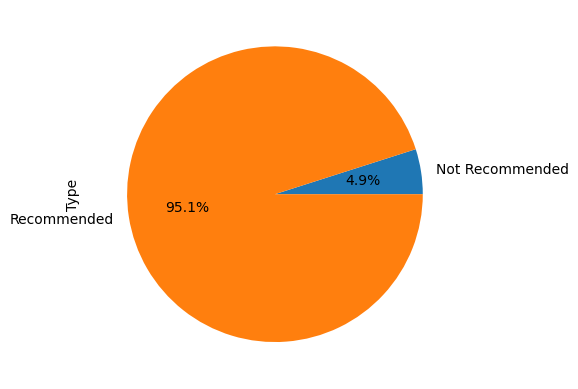

In [20]:
# Checking the distribution of dependent variable column 'reviews.doRecommend'
# Because the sample is very skewed towards recommending the product, we apply downsampling to even out reviews that recommend the product and the reviews that do not recommend
plt.pie(firetablet_df.groupby("reviews.doRecommend").size(), labels=["Not Recommended", "Recommended"], autopct="%1.1f%%")
plt.ylabel("Type")
plt.show()

## Downsampling

In [21]:
# Determining the size of reviews that do recommend the product
recommend = firetablet_df[firetablet_df["reviews.doRecommend"] == 1]
recommend.shape

(12063, 4)

In [22]:
# Determining the size of reviews that do not recommend the product
notrecommend = firetablet_df[firetablet_df["reviews.doRecommend"] == 0]
notrecommend.shape

(625, 4)

In [23]:
# Downsampling
np.random.seed(42)
downsample = resample(recommend, replace=True, n_samples=len(notrecommend), random_state=42)
downsample.shape

(625, 4)

In [24]:
firetablet_df_sample = pd.concat([downsample, notrecommend], ignore_index=True)
firetablet_df_sample

,name,reviews.doRecommend,reviews.text,review_clean
0,Fire Tablet,1,This is a great tablet for the price. You can'...,great tablet price ca beat usage device readin...
1,Fire Tablet,1,Bought this for my 10 year old for Christmas s...,bought year old christmas going love already d...
2,Fire Tablet,1,This is my first tablet and I really like it. ...,first tablet really like easy use like touch s...
3,Fire Tablet,1,Cant beat the price for a tablet. This is the ...,cant beat price tablet best bang buck
4,Fire Tablet,1,I enjoy reading with my Kindle Fire. That is t...,enjoy reading kindle fire reason purchased not...
...,...,...,...,...
1245,Fire Tablet,0,I purchased this since I bought my grandson th...,purchased since bought grandson tablet christm...
1246,Fire Tablet,0,I I thought the buy For my child bc the kids m...,thought buy child bc kids mode poor
1247,Fire Tablet,0,"Great Product, User Friendly and can't be beat...",great product user friendly ca beaten promotio...
1248,Fire Tablet,0,It is a solid product great for kids I like it...,solid product great kids like lot


In [25]:
print(firetablet_df_sample["reviews.doRecommend"].value_counts())

1    625
0    625
Name: reviews.doRecommend, dtype: int64


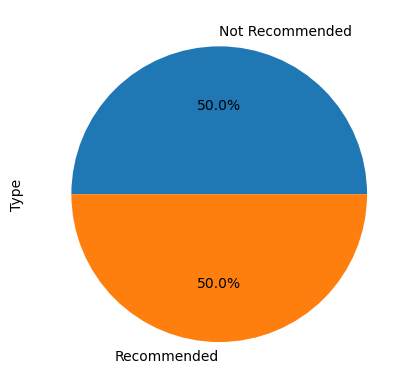

In [26]:
# Finalized sample is much more even not with a 50-50 split
plt.pie(firetablet_df_sample.groupby("reviews.doRecommend").size(), labels=["Not Recommended", "Recommended"], autopct="%1.1f%%")
plt.ylabel("Type")
plt.show()

# Data Exploratory

In [27]:
# Finding most common words used in reviews
reviews = ','.join(alldf['review_clean'])
tokenized_reviews = nltk.word_tokenize(reviews)
tokenized_reviews = [w for w in tokenized_reviews if w.isalpha()]
fd_reviews = nltk.FreqDist(tokenized_reviews)
fd_reviews.most_common(20)

[('great', 22791),
 ('tablet', 16939),
 ('use', 13149),
 ('good', 11571),
 ('love', 11258),
 ('not', 11226),
 ('amazon', 10396),
 ('easy', 9904),
 ('price', 9814),
 ('bought', 9018),
 ('kindle', 9001),
 ('one', 8529),
 ('batteries', 8130),
 ('fire', 7463),
 ('like', 6864),
 ('would', 6126),
 ('product', 6088),
 ('kids', 5622),
 ('well', 5365),
 ('loves', 5346)]

In [28]:
true_reviews_df = firetablet_df_sample.loc[(firetablet_df_sample["name"] == "Fire Tablet") & (firetablet_df_sample["reviews.doRecommend"] == 1)]
true_reviews_df

false_reviews_df = firetablet_df_sample.loc[(firetablet_df_sample["name"] == "Fire Tablet") & (firetablet_df_sample["reviews.doRecommend"] == 0)]
#false_reviews_df

In [29]:
not_recommended_review = false_reviews_df["review_clean"]
not_recommended_review = list(not_recommended_review)

recommended_review = true_reviews_df["review_clean"]
recommended_review = list(recommended_review)

print(len(not_recommended_review))
print(len(recommended_review))

625
625


In [30]:
# Determining TF-IDF scores
def _create_frequency_matrix(sentences):
    frequency_matrix = {} # table

    for (i, sent) in enumerate(sentences):
        freq_table = {} # dictionary
        words = word_tokenize(sent)
        for word in words:
            if word in freq_table:
                freq_table[word] += 1 # key of the dictionary freq_table is 'word'
            else:
                freq_table[word] = 1

        frequency_matrix[i] = freq_table 
    return frequency_matrix


def _create_frequency_matrix1(bigrams):
    freq_matrix = {}
    for i, bigram in enumerate(bigrams):
        freq_table = {} # dictionary
        for word in bigram:
            if word in freq_table:    
                freq_table[word] += 1
            else:
                freq_table[word] = 1   
        freq_matrix[i] = freq_table     
    return freq_matrix


def _create_tf_matrix(freq_matrix):
    tf_matrix = {}
    for sent, f_table in freq_matrix.items():
        tf_table = {}
        count_words_in_sentence = len(f_table)
        for word, count in f_table.items():
            tf_table[word] = count / count_words_in_sentence
        tf_matrix[sent] = tf_table
    return tf_matrix


def _create_documents_per_words(freq_matrix):
    word_per_doc_table = {}
    for sent, f_table in freq_matrix.items():
        for word, count in f_table.items():
            if word in word_per_doc_table:
                word_per_doc_table[word] += 1
            else:
                word_per_doc_table[word] = 1
    return word_per_doc_table


def _create_idf_matrix(freq_matrix, count_doc_per_words, total_documents):
    idf_matrix = {}
    for sent, f_table in freq_matrix.items():
        idf_table = {}
        for word in f_table.keys():
            idf_table[word] = math.log10(total_documents / float(count_doc_per_words[word]))
        idf_matrix[sent] = idf_table
    return idf_matrix


def _create_tf_idf_matrix(tf_matrix, idf_matrix):
    tf_idf_matrix = {}
    for (sent1, f_table1), (sent2, f_table2) in zip(tf_matrix.items(), idf_matrix.items()):
        tf_idf_table = {}
        for (word1, value1), (word2, value2) in zip(f_table1.items(),
                                                    f_table2.items()):  # here, keys are the same in both the table
            tf_idf_table[word1] = float(value1 * value2)
        tf_idf_matrix[sent1] = tf_idf_table
    return tf_idf_matrix


def aggregate_scores(tfidf_matrix):    
    aggregated_scores = {}
    for index, scores in tfidf_matrix.items():        
        sentence_score = sum(scores.values()) / len(scores)        
        words = list(scores.keys())        
        aggregated_scores[index] = (words,sentence_score)        
    return aggregated_scores

In [31]:
# TF-IDF scores of words in reviews that do not recommend the Fire Tablet
freq_matrix = _create_frequency_matrix(not_recommended_review)
tf_matrix = _create_tf_matrix(freq_matrix)
count_doc_per_words = _create_documents_per_words(freq_matrix)
total_documents = len(not_recommended_review)
idf_matrix = _create_idf_matrix(freq_matrix, count_doc_per_words, total_documents)
not_recommend_tf_idf_matrix = _create_tf_idf_matrix(tf_matrix, idf_matrix)
not_recommend_tf_idf_matrix

{0: {'disappointed': 0.1553266676302264,
  'realize': 0.22419208521782572,
  'not': 0.042322963263695244,
  'light': 0.20462638976719447,
  'night': 0.22419208521782572,
  'reading': 0.1553266676302264,
  'size': 0.1949430369095389,
  'weight': 0.25763986251382365,
  'great': 0.09980588067262597},
 1: {'thought': 0.08696839422032229,
  'would': 0.07844165621163081,
  'big': 0.08998826434935521,
  'small': 0.16609444685334376,
  'paper': 0.11209604260891286,
  'turn': 0.08187004014500866,
  'like': 0.04445804570814029,
  'palm': 0.1553266676302264,
  'think': 0.08558930623559828,
  'read': 0.06820434962650446,
  'not': 0.021161481631847622,
  'comfortable': 0.13860277898222745,
  'regular': 0.1218788903342285,
  'kindle': 0.05694600031677394,
  'definitely': 0.09165288787032429,
  'recommend': 0.07024450557232333,
  'paperwhite': 0.1553266676302264,
  'instead': 0.09747151845476945},
 2: {'opinion': 0.26211375162600703,
  'model': 0.2102420831296548,
  'small': 0.18685625271001174,
  'f

In [32]:
# TF-IDF scores of words in reviews that do recommend the Fire Tablet
freq_matrix = _create_frequency_matrix(recommended_review)
tf_matrix = _create_tf_matrix(freq_matrix)
count_doc_per_words = _create_documents_per_words(freq_matrix)
total_documents = len(recommended_review)
idf_matrix = _create_idf_matrix(freq_matrix, count_doc_per_words, total_documents)
recommend_tf_idf_matrix = _create_tf_idf_matrix(tf_matrix, idf_matrix)
recommend_tf_idf_matrix

{0: {'great': 0.030628018899703045,
  'tablet': 0.04990347872989921,
  'price': 0.0452405814458874,
  'ca': 0.08604866926827795,
  'beat': 0.10798591721922625,
  'usage': 0.1863920011562717,
  'device': 0.10436207306438676,
  'reading': 0.07682848939052585,
  'kindle': 0.05845346166453342,
  'books': 0.07617783357124877,
  'yes': 0.1545839175082942,
  'would': 0.08032102735450507,
  'recommend': 0.0968971557681246,
  'looking': 0.09561014542176549,
  'simple': 0.10611733564587669},
 1: {'bought': 0.055976473507531814,
  'year': 0.09928692607878224,
  'old': 0.08941627398188375,
  'christmas': 0.1836646193870943,
  'going': 0.13814461671877504,
  'love': 0.06364592836847231,
  'already': 0.15520990515080244,
  'downloaded': 0.15520990515080244,
  'bunch': 0.19191154012923803,
  'book': 0.13496056401429618,
  'apps': 0.09354587851748193,
  'set': 0.12244307959139619,
  'morning': 0.21506769364185196},
 2: {'first': 0.08122980408077983,
  'tablet': 0.04403248123226401,
  'really': 0.07221

In [33]:
# Aggregating all TF-IDF scores for reviews that do not recommend product
aggregated_tfidf = {}

for sentence in not_recommend_tf_idf_matrix.values():
    for word, tfidf_score in sentence.items():
        if word not in aggregated_tfidf:
            aggregated_tfidf[word] = 0
        aggregated_tfidf[word] += tfidf_score
        
sorted_features = sorted(aggregated_tfidf.items(), key=lambda x: x[1], reverse=True)

# Top 10 features for not recommended  reviews 
top = 10
not_recommended_features = dict(sorted_features[:top])
not_recommended_features

{'not': 8.762530155719512,
 'tablet': 8.331683628597009,
 'good': 6.743563682317318,
 'apps': 6.37066207944539,
 'slow': 6.249923696750597,
 'like': 6.138129269001661,
 'amazon': 5.930111342954671,
 'use': 5.925641790307382,
 'great': 5.761926823243612,
 'price': 5.684919042560864}

In [34]:
# Aggregating all TF-IDF scores for reviews that do recommend product
aggregated_tfidf1 = {}

for sentence in recommend_tf_idf_matrix.values():
    for word, tfidf_score in sentence.items():
        if word not in aggregated_tfidf1:
            aggregated_tfidf1[word] = 0
        aggregated_tfidf1[word] += tfidf_score
        
sorted_features = sorted(aggregated_tfidf1.items(), key=lambda x: x[1], reverse=True)

# Top 10 features for do recommended  reviews
top = 10
recommended_features = dict(sorted_features[:top])
recommended_features

{'great': 12.884568120448876,
 'tablet': 11.422911870477488,
 'love': 10.056592279215783,
 'good': 9.913811593257284,
 'price': 9.77537915386166,
 'bought': 9.13496343666937,
 'easy': 8.815372458023788,
 'use': 8.611326605521612,
 'loves': 7.793732447129089,
 'gift': 7.499549581575197}

# Bigramming

In [35]:
# We bigram words in the sentences to identify 2 words that often appear together
def sentence_bigrams(sentence):
    words = nltk.word_tokenize(sentence)
    sentence_bigrams = list(nltk.bigrams(words))
    return sentence_bigrams

In [36]:
not_recommended_review = false_reviews_df["review_clean"]
not_recommended_review = list(not_recommended_review)

recommended_review = true_reviews_df["review_clean"]
recommended_review = list(recommended_review)

In [37]:
recommended_review

['great tablet price ca beat usage device reading kindle books yes would recommend looking simple tablet',
 'bought year old christmas going love already downloaded bunch book apps set christmas morning',
 'first tablet really like easy use like touch screen lot better tablet kid got another store perfect size hand',
 'cant beat price tablet best bang buck',
 'enjoy reading kindle fire reason purchased not use limited',
 'tablet great easy use convenient handy around',
 'liked product lot web surfing skype great',
 'kindle fire great tablet alot different apps easy use',
 'pretty easy use small enough little hands nice card slot toexpand memory',
 'great price works well needed no need spend hundreds tablets',
 'son loves kindle loves layout software easy download apps user friendly interface bought storage bought expandable external storage make robust durable love child settings limit use necessary',
 'bought present year old grandma loves easy operate no issues',
 'works well one or

In [38]:
# Most common bigrams for reviews that do not recommend
not_recommend_bigrams = [sentence_bigrams(sentence) for sentence in not_recommended_review]
not_recommend_bigrams = [w for s in not_recommend_bigrams for w in s]
freq_matrix = _create_frequency_matrix1(not_recommend_bigrams)
tf_matrix = _create_tf_matrix(freq_matrix)
count_doc_per_words = _create_documents_per_words(freq_matrix)
total_documents = len(not_recommend_bigrams)
idf_matrix = _create_idf_matrix(freq_matrix, count_doc_per_words, total_documents)
false_bigram_tf_idf_matrix = _create_tf_idf_matrix(tf_matrix, idf_matrix)
not_recommend_bigram = aggregate_scores(false_bigram_tf_idf_matrix)
not_recommend_bigram

{0: (['disappointed', 'realize'], 1.3799531079402745),
 1: (['realize', 'not'], 1.0747437113849008),
 2: (['not', 'light'], 1.0050553111466936),
 3: (['light', 'night'], 1.432099812677404),
 4: (['night', 'reading'], 1.3270457118316066),
 5: (['reading', 'size'], 1.2830228970676862),
 6: (['size', 'weight'], 1.5330228970676862),
 7: (['weight', 'great'], 1.3132284396710534),
 8: (['thought', 'would'], 1.0413589842923465),
 9: (['would', 'big'], 1.0479412189729338),
 10: (['big', 'small'], 1.253665613360298),
 11: (['small', 'paper'], 1.343421099020715),
 12: (['paper', 'turn'], 1.343421099020715),
 13: (['turn', 'like'], 1.0395211489358762),
 14: (['like', 'palm'], 1.3726307639147775),
 15: (['palm', 'think'], 1.583434237949704),
 16: (['think', 'small'], 1.2503246229708025),
 17: (['small', 'read'], 1.1514996448443453),
 18: (['read', 'not'], 0.8462902482889716),
 19: (['not', 'comfortable'], 1.1742287135529101),
 20: (['comfortable', 'regular'], 1.6620327272551945),
 21: (['regular',

In [39]:
# Not recommend bigram words
result = [(bigram, score) for bigram, score in not_recommend_bigram.items()]
not_recommend_bigram_sorted = sorted(result, key=lambda x: float(x[1][1]), reverse=True)
not_recommend_bigram_sorted = not_recommend_bigram_sorted[31:]
not_recommend_bigram_sorted

[(411, (['pro', 'gps'], 1.9630627229191755)),
 (1059, (['agreements', 'sharge'], 1.9630627229191755)),
 (4276, (['powerwhite', 'elephant'], 1.9630627229191755)),
 (7909, (['excelent', 'talber'], 1.9630627229191755)),
 (8888, (['burn', 'explode'], 1.9630627229191755)),
 (9448, (['pros', 'inexpensiveexpandable'], 1.9630627229191755)),
 (10092, (['blue', 'ray'], 1.9630627229191755)),
 (10163, (['sources', 'kick'], 1.9630627229191755)),
 (10321, (['rings', 'true'], 1.9630627229191755)),
 (152, (['inadvertant', 'tap'], 1.8878052240031804)),
 (157, (['twitchy', 'finger'], 1.8878052240031804)),
 (158, (['finger', 'rabbit'], 1.8878052240031804)),
 (254, (['listening', 'audiobooks'], 1.8878052240031804)),
 (412, (['gps', 'accurate'], 1.8878052240031804)),
 (419, (['stairs', 'adequately'], 1.8878052240031804)),
 (493, (['cc', 'file'], 1.8878052240031804)),
 (517, (['comparisons', 'unavoidable'], 1.8878052240031804)),
 (715, (['shield', 'proof'], 1.8878052240031804)),
 (730, (['air', 'w'], 1.8878

In [40]:
# Recommend bigram words
recommend_bigrams = [sentence_bigrams(sentence) for sentence in recommended_review]
recommend_bigrams = [w for s in recommend_bigrams for w in s]
freq_matrix = _create_frequency_matrix1(recommend_bigrams)
tf_matrix = _create_tf_matrix(freq_matrix)
count_doc_per_words = _create_documents_per_words(freq_matrix)
total_documents = len(recommend_bigrams)
idf_matrix = _create_idf_matrix(freq_matrix, count_doc_per_words, total_documents)
recommend_bigram_tf_idf_matrix = _create_tf_idf_matrix(tf_matrix, idf_matrix)
recommend_bigram = aggregate_scores(recommend_bigram_tf_idf_matrix)
recommend_bigram

{0: (['great', 'tablet'], 0.5860840187403777),
 1: (['tablet', 'price'], 0.6498048132118592),
 2: (['price', 'ca'], 0.8934958573578409),
 3: (['ca', 'beat'], 1.1342678365246481),
 4: (['beat', 'usage'], 1.5071082599832164),
 5: (['usage', 'device'], 1.4820794717623993),
 6: (['device', 'reading'], 1.0712163026408523),
 7: (['reading', 'kindle'], 0.8832607247255287),
 8: (['kindle', 'books'], 0.874950491440859),
 9: (['books', 'yes'], 1.2512379860208354),
 10: (['yes', 'would'], 1.264599065827577),
 11: (['would', 'recommend'], 1.061370726666863),
 12: (['recommend', 'looking'], 1.1392445840023995),
 13: (['looking', 'simple'], 1.1509937246714554),
 14: (['simple', 'tablet'], 0.8624007223308443),
 15: (['bought', 'year'], 0.9249850441877928),
 16: (['year', 'old'], 1.0046236293496713),
 17: (['old', 'christmas'], 0.979398505414456),
 18: (['christmas', 'going'], 1.136495737927034),
 19: (['going', 'love'], 1.0716526339198946),
 20: (['love', 'already'], 1.1365619615463336),
 21: (['alre

In [43]:
# Top do not recommend review bigram words in descending order
result = [(bigram, score) for bigram, score in recommend_bigram.items()]
recommend_bigram_sorted = sorted(result, key=lambda x: float(x[1][1]), reverse=True)
recommend_bigram_sorted
recommend_bigram_sorted = recommend_bigram_sorted[22:]
recommend_bigram_sorted[:20]

[(51, (['bang', 'buck'], 1.8649492010229631)),
 (1373, (['sea', 'choices'], 1.8649492010229631)),
 (2213, (['info', 'quickly'], 1.8649492010229631)),
 (2307, (['sideloaded', 'file'], 1.8649492010229631)),
 (3161, (['commute', 'train'], 1.8649492010229631)),
 (5027, (['primary', 'tool'], 1.8649492010229631)),
 (5528, (['ot', 'shuts'], 1.8649492010229631)),
 (5667, (['portrait', 'landscape'], 1.8649492010229631)),
 (5708, (['exelent', 'shoppin'], 1.8649492010229631)),
 (7008, (['author', 'frequently'], 1.8649492010229631)),
 (7346, (['community', 'reach'], 1.8649492010229631)),
 (7401, (['growing', 'adulthood'], 1.8649492010229631)),
 (7569, (['practically', 'anybody'], 1.8649492010229631)),
 (380, (['extended', 'period'], 1.7896917021069678)),
 (464, (['segment', 'resourcelful'], 1.7896917021069678)),
 (503, (['says', 'expendable'], 1.7896917021069678)),
 (526, (['required', 'link'], 1.7896917021069678)),
 (554, (['abc', 'mouse'], 1.7896917021069678)),
 (586, (['charger', 'seemed'], 1.7

# POS Tagging

#### Recommened Reviews

In [41]:
# POS tagging words for reviews that recommend product
recommend_review = ' '.join(recommended_review)
recommend_review = nltk.word_tokenize(recommend_review)
recommend_reviews_tagged = pos_tag(recommend_review)
recommend_most_common = FreqDist(recommend_reviews_tagged)
recommend_most_common.most_common(20)

[(('tablet', 'NN'), 269),
 (('great', 'JJ'), 262),
 (('price', 'NN'), 140),
 (('good', 'JJ'), 120),
 (('easy', 'JJ'), 118),
 (('use', 'NN'), 117),
 (('bought', 'VBD'), 112),
 (('not', 'RB'), 107),
 (('one', 'CD'), 91),
 (('kids', 'NNS'), 67),
 (('fire', 'NN'), 66),
 (('games', 'NNS'), 60),
 (('gift', 'NN'), 56),
 (('got', 'VBD'), 54),
 (('like', 'IN'), 53),
 (('product', 'NN'), 52),
 (('books', 'NNS'), 49),
 (('kindle', 'JJ'), 45),
 (('old', 'JJ'), 44),
 (('would', 'MD'), 43)]

In [44]:
recommended_words = [item[1][0] for item in recommend_bigram_sorted]
recommended_words

[['bang', 'buck'],
 ['sea', 'choices'],
 ['info', 'quickly'],
 ['sideloaded', 'file'],
 ['commute', 'train'],
 ['primary', 'tool'],
 ['ot', 'shuts'],
 ['portrait', 'landscape'],
 ['exelent', 'shoppin'],
 ['author', 'frequently'],
 ['community', 'reach'],
 ['growing', 'adulthood'],
 ['practically', 'anybody'],
 ['extended', 'period'],
 ['segment', 'resourcelful'],
 ['says', 'expendable'],
 ['required', 'link'],
 ['abc', 'mouse'],
 ['charger', 'seemed'],
 ['frustration', 'downloads'],
 ['downloads', 'start'],
 ['start', 'circling'],
 ['streams', 'directly'],
 ['directly', 'receiver'],
 ['name', 'rebecca'],
 ['delighted', 'number'],
 ['seven', 'inches'],
 ['complained', 'addicted'],
 ['addicted', 'guess'],
 ['stand', 'sea'],
 ['minor', 'task'],
 ['come', 'blurry'],
 ['benefit', 'adding'],
 ['step', 'leappad'],
 ['clash', 'clans'],
 ['youtubekids', 'caught'],
 ['caught', 'saying'],
 ['worried', 'gig'],
 ['car', 'rides'],
 ['save', 'cell'],
 ['autism', 'helping'],
 ['helping', 'development'

In [45]:
recommend_words_filtered = [words for words in recommended_words if len(words) > 1]
recommend_words_filtered = [str(word) for sublist in recommend_words_filtered for word in sublist]
recommend_words_filtered

['bang',
 'buck',
 'sea',
 'choices',
 'info',
 'quickly',
 'sideloaded',
 'file',
 'commute',
 'train',
 'primary',
 'tool',
 'ot',
 'shuts',
 'portrait',
 'landscape',
 'exelent',
 'shoppin',
 'author',
 'frequently',
 'community',
 'reach',
 'growing',
 'adulthood',
 'practically',
 'anybody',
 'extended',
 'period',
 'segment',
 'resourcelful',
 'says',
 'expendable',
 'required',
 'link',
 'abc',
 'mouse',
 'charger',
 'seemed',
 'frustration',
 'downloads',
 'downloads',
 'start',
 'start',
 'circling',
 'streams',
 'directly',
 'directly',
 'receiver',
 'name',
 'rebecca',
 'delighted',
 'number',
 'seven',
 'inches',
 'complained',
 'addicted',
 'addicted',
 'guess',
 'stand',
 'sea',
 'minor',
 'task',
 'come',
 'blurry',
 'benefit',
 'adding',
 'step',
 'leappad',
 'clash',
 'clans',
 'youtubekids',
 'caught',
 'caught',
 'saying',
 'worried',
 'gig',
 'car',
 'rides',
 'save',
 'cell',
 'autism',
 'helping',
 'helping',
 'development',
 'brand',
 'troubles',
 'bb',
 'clerk',

In [46]:
recommend_words_filtered = pos_tag(recommend_words_filtered)

In [47]:
recommend_words_filtered

[('bang', 'NN'),
 ('buck', 'VBD'),
 ('sea', 'NN'),
 ('choices', 'NNS'),
 ('info', 'JJ'),
 ('quickly', 'RB'),
 ('sideloaded', 'VBD'),
 ('file', 'JJ'),
 ('commute', 'NN'),
 ('train', 'NN'),
 ('primary', 'JJ'),
 ('tool', 'NN'),
 ('ot', 'NN'),
 ('shuts', 'VBZ'),
 ('portrait', 'JJ'),
 ('landscape', 'NN'),
 ('exelent', 'NN'),
 ('shoppin', 'NN'),
 ('author', 'NN'),
 ('frequently', 'RB'),
 ('community', 'NN'),
 ('reach', 'VBP'),
 ('growing', 'VBG'),
 ('adulthood', 'NN'),
 ('practically', 'RB'),
 ('anybody', 'NN'),
 ('extended', 'JJ'),
 ('period', 'NN'),
 ('segment', 'NN'),
 ('resourcelful', 'NN'),
 ('says', 'VBZ'),
 ('expendable', 'JJ'),
 ('required', 'VBN'),
 ('link', 'NN'),
 ('abc', 'NN'),
 ('mouse', 'NN'),
 ('charger', 'NN'),
 ('seemed', 'VBD'),
 ('frustration', 'JJ'),
 ('downloads', 'NNS'),
 ('downloads', 'NNS'),
 ('start', 'VBP'),
 ('start', 'VB'),
 ('circling', 'VBG'),
 ('streams', 'NNS'),
 ('directly', 'RB'),
 ('directly', 'RB'),
 ('receiver', 'VB'),
 ('name', 'NN'),
 ('rebecca', 'NN'),

In [48]:
word_tag_pairs = nltk.bigrams(recommend_words_filtered)
word_tag_pairs = list(word_tag_pairs)
part_of_speech = [a[1] for (a, b) in word_tag_pairs if b[1]=="NN"]
fdist = nltk.FreqDist(part_of_speech)
most_common_pos_before_noun = fdist.most_common()
most_common_pos_before_noun

[('NN', 1879),
 ('JJ', 1710),
 ('VBG', 155),
 ('VBD', 150),
 ('VB', 149),
 ('VBP', 148),
 ('NNS', 147),
 ('RB', 109),
 ('IN', 85),
 ('VBN', 82),
 ('CD', 74),
 ('VBZ', 66),
 ('JJR', 49),
 ('DT', 48),
 ('JJS', 47),
 ('RBR', 18),
 ('MD', 8),
 ('FW', 4),
 ('RP', 4),
 ('CC', 3),
 ('NNP', 3),
 ('WRB', 3),
 ('PRP', 2),
 ('WDT', 2),
 ('RBS', 2)]

In [49]:
# Most common words before the nouns
part_of_speech1 = [a[0] for (a, b) in word_tag_pairs if b[1]=="NN"]
fdist = nltk.FreqDist(part_of_speech1)
most_common_word_before_noun = fdist.most_common()
most_common_word_before_noun

[('tablet', 219),
 ('great', 198),
 ('easy', 138),
 ('good', 113),
 ('price', 97),
 ('use', 90),
 ('fire', 82),
 ('love', 70),
 ('kindle', 69),
 ('amazon', 60),
 ('one', 58),
 ('bought', 56),
 ('old', 52),
 ('gift', 46),
 ('screen', 36),
 ('best', 36),
 ('like', 34),
 ('purchased', 32),
 ('perfect', 31),
 ('nice', 29),
 ('christmas', 29),
 ('product', 29),
 ('able', 28),
 ('apps', 26),
 ('much', 26),
 ('read', 26),
 ('battery', 25),
 ('happy', 25),
 ('no', 25),
 ('first', 24),
 ('small', 24),
 ('reading', 23),
 ('better', 23),
 ('quality', 22),
 ('decent', 21),
 ('watch', 21),
 ('internet', 21),
 ('size', 20),
 ('time', 20),
 ('kids', 19),
 ('store', 19),
 ('play', 18),
 ('memory', 18),
 ('device', 17),
 ('download', 17),
 ('want', 17),
 ('enough', 16),
 ('buy', 16),
 ('not', 16),
 ('prime', 15),
 ('daughter', 15),
 ('money', 15),
 ('need', 15),
 ('year', 15),
 ('recommend', 15),
 ('looking', 15),
 ('new', 14),
 ('little', 14),
 ('everything', 14),
 ('black', 14),
 ('loves', 14),
 ('si

In [50]:
# Most common words that are nouns
part_of_speech1 = [b[0] for (a, b) in word_tag_pairs if b[1]=="NN"]
fdist = nltk.FreqDist(part_of_speech1)
fdist2 = nltk.FreqDist(part_of_speech1)
most_common_noun_word = fdist.most_common()
most_common_noun_word

[('tablet', 479),
 ('price', 248),
 ('use', 232),
 ('fire', 126),
 ('product', 94),
 ('gift', 92),
 ('year', 65),
 ('amazon', 63),
 ('time', 61),
 ('kindle', 61),
 ('size', 57),
 ('screen', 52),
 ('quality', 51),
 ('love', 49),
 ('son', 48),
 ('christmas', 45),
 ('everything', 45),
 ('buy', 43),
 ('something', 40),
 ('lot', 39),
 ('battery', 38),
 ('life', 34),
 ('daughter', 34),
 ('memory', 34),
 ('purchase', 34),
 ('store', 33),
 ('wife', 32),
 ('internet', 32),
 ('apps', 31),
 ('money', 30),
 ('play', 29),
 ('device', 28),
 ('phone', 27),
 ('camera', 27),
 ('day', 27),
 ('download', 27),
 ('watch', 27),
 ('music', 24),
 ('way', 24),
 ('family', 23),
 ('access', 22),
 ('work', 22),
 ('book', 22),
 ('cost', 21),
 ('deal', 21),
 ('thing', 20),
 ('value', 20),
 ('problem', 19),
 ('picture', 19),
 ('web', 19),
 ('anyone', 18),
 ('mom', 18),
 ('charge', 17),
 ('storage', 17),
 ('display', 17),
 ('card', 17),
 ('job', 17),
 ('age', 16),
 ('everyone', 16),
 ('home', 15),
 ('anything', 15),


#### Do not recommend reviews

In [51]:
# POS tagging words for reviews that do not recommend product
not_recommend_review = ' '.join(not_recommended_review)
not_recommend_review = nltk.word_tokenize(not_recommend_review)
not_recommend_review = pos_tag(not_recommend_review)
not_recommend_most_common = FreqDist(not_recommend_review)
not_recommend_most_common

FreqDist({('not', 'RB'): 378, ('tablet', 'NN'): 292, ('would', 'MD'): 146, ('good', 'JJ'): 123, ('one', 'CD'): 116, ('like', 'IN'): 113, ('amazon', 'NN'): 93, ('bought', 'VBD'): 91, ('fire', 'NN'): 88, ('price', 'NN'): 88, ...})

In [52]:
not_recommend_words = [item[1][0] for item in not_recommend_bigram_sorted]
not_recommend_words

[['pro', 'gps'],
 ['agreements', 'sharge'],
 ['powerwhite', 'elephant'],
 ['excelent', 'talber'],
 ['burn', 'explode'],
 ['pros', 'inexpensiveexpandable'],
 ['blue', 'ray'],
 ['sources', 'kick'],
 ['rings', 'true'],
 ['inadvertant', 'tap'],
 ['twitchy', 'finger'],
 ['finger', 'rabbit'],
 ['listening', 'audiobooks'],
 ['gps', 'accurate'],
 ['stairs', 'adequately'],
 ['cc', 'file'],
 ['comparisons', 'unavoidable'],
 ['shield', 'proof'],
 ['air', 'w'],
 ['crack', 'bearly'],
 ['increased', 'useage'],
 ['fountains', 'el'],
 ['el', 'paso'],
 ['paso', 'texas'],
 ['inspect', 'sticker'],
 ['bite', 'bullet'],
 ['starbucks', 'hotels'],
 ['agree', 'terms'],
 ['compters', 'cell'],
 ['across', 'town'],
 ['defaulty', 'equipment'],
 ['heard', 'common'],
 ['technical', 'knowledge'],
 ['glitchy', 'pixelly'],
 ['hp', 'pc'],
 ['sells', 'practices'],
 ['overheated', 'shorted'],
 ['identity', 'theft'],
 ['theft', 'prevalent'],
 ['bust', 'throw'],
 ['letters', 'words'],
 ['vid', 'utube'],
 ['utube', 'pic'],


In [53]:
not_recommend_words_filtered = [words for words in not_recommend_words if len(words) > 1]
not_recommend_words_filtered = [str(word) for sublist in not_recommend_words_filtered for word in sublist]
not_recommend_words_filtered

['pro',
 'gps',
 'agreements',
 'sharge',
 'powerwhite',
 'elephant',
 'excelent',
 'talber',
 'burn',
 'explode',
 'pros',
 'inexpensiveexpandable',
 'blue',
 'ray',
 'sources',
 'kick',
 'rings',
 'true',
 'inadvertant',
 'tap',
 'twitchy',
 'finger',
 'finger',
 'rabbit',
 'listening',
 'audiobooks',
 'gps',
 'accurate',
 'stairs',
 'adequately',
 'cc',
 'file',
 'comparisons',
 'unavoidable',
 'shield',
 'proof',
 'air',
 'w',
 'crack',
 'bearly',
 'increased',
 'useage',
 'fountains',
 'el',
 'el',
 'paso',
 'paso',
 'texas',
 'inspect',
 'sticker',
 'bite',
 'bullet',
 'starbucks',
 'hotels',
 'agree',
 'terms',
 'compters',
 'cell',
 'across',
 'town',
 'defaulty',
 'equipment',
 'heard',
 'common',
 'technical',
 'knowledge',
 'glitchy',
 'pixelly',
 'hp',
 'pc',
 'sells',
 'practices',
 'overheated',
 'shorted',
 'identity',
 'theft',
 'theft',
 'prevalent',
 'bust',
 'throw',
 'letters',
 'words',
 'vid',
 'utube',
 'utube',
 'pic',
 'pic',
 'cut',
 'fingerprint',
 'magnet',


In [54]:
not_recommend_words_tagged = pos_tag(not_recommend_words_filtered)
not_recommend_words_tagged

[('pro', 'JJ'),
 ('gps', 'NN'),
 ('agreements', 'NNS'),
 ('sharge', 'VBP'),
 ('powerwhite', 'JJ'),
 ('elephant', 'JJ'),
 ('excelent', 'NN'),
 ('talber', 'NN'),
 ('burn', 'VBP'),
 ('explode', 'NN'),
 ('pros', 'NNS'),
 ('inexpensiveexpandable', 'JJ'),
 ('blue', 'JJ'),
 ('ray', 'NN'),
 ('sources', 'NNS'),
 ('kick', 'VBP'),
 ('rings', 'NNS'),
 ('true', 'JJ'),
 ('inadvertant', 'JJ'),
 ('tap', 'NN'),
 ('twitchy', 'NN'),
 ('finger', 'NN'),
 ('finger', 'NN'),
 ('rabbit', 'NN'),
 ('listening', 'VBG'),
 ('audiobooks', 'NNS'),
 ('gps', 'JJ'),
 ('accurate', 'JJ'),
 ('stairs', 'NNS'),
 ('adequately', 'RB'),
 ('cc', 'VBP'),
 ('file', 'JJ'),
 ('comparisons', 'NNS'),
 ('unavoidable', 'JJ'),
 ('shield', 'JJ'),
 ('proof', 'NN'),
 ('air', 'NN'),
 ('w', 'VBP'),
 ('crack', 'NN'),
 ('bearly', 'RB'),
 ('increased', 'VBD'),
 ('useage', 'NN'),
 ('fountains', 'NNS'),
 ('el', 'VBP'),
 ('el', 'JJ'),
 ('paso', 'NN'),
 ('paso', 'NN'),
 ('texas', 'NN'),
 ('inspect', 'NN'),
 ('sticker', 'NN'),
 ('bite', 'JJ'),
 ('bul

In [55]:
not_recommend_tag_pairs = nltk.bigrams(not_recommend_words_tagged)
not_recommend_tag_pairs = list(not_recommend_tag_pairs)
part_of_speech = [a[1] for (a, b) in not_recommend_tag_pairs if b[1]=="NN"]
fdist = nltk.FreqDist(part_of_speech)
most_common_pos_before_noun = fdist.most_common()
most_common_pos_before_noun

[('NN', 3086),
 ('JJ', 2240),
 ('VBD', 283),
 ('VBG', 281),
 ('VB', 267),
 ('VBP', 253),
 ('NNS', 195),
 ('RB', 192),
 ('VBN', 181),
 ('IN', 177),
 ('DT', 116),
 ('CD', 113),
 ('JJS', 78),
 ('VBZ', 71),
 ('JJR', 52),
 ('RBR', 25),
 ('MD', 23),
 ('FW', 8),
 ('RP', 5),
 ('CC', 3),
 ('WRB', 2),
 ('RBS', 2),
 ('WP$', 1),
 ('WDT', 1),
 ('WP', 1)]

In [56]:
# Most common words before the nouns 
part_of_speech = [a[0] for (a, b) in word_tag_pairs if b[1]=="NN"]
fdist = nltk.FreqDist(part_of_speech)
most_common_word_before_noun = fdist.most_common()
most_common_word_before_noun

[('tablet', 219),
 ('great', 198),
 ('easy', 138),
 ('good', 113),
 ('price', 97),
 ('use', 90),
 ('fire', 82),
 ('love', 70),
 ('kindle', 69),
 ('amazon', 60),
 ('one', 58),
 ('bought', 56),
 ('old', 52),
 ('gift', 46),
 ('screen', 36),
 ('best', 36),
 ('like', 34),
 ('purchased', 32),
 ('perfect', 31),
 ('nice', 29),
 ('christmas', 29),
 ('product', 29),
 ('able', 28),
 ('apps', 26),
 ('much', 26),
 ('read', 26),
 ('battery', 25),
 ('happy', 25),
 ('no', 25),
 ('first', 24),
 ('small', 24),
 ('reading', 23),
 ('better', 23),
 ('quality', 22),
 ('decent', 21),
 ('watch', 21),
 ('internet', 21),
 ('size', 20),
 ('time', 20),
 ('kids', 19),
 ('store', 19),
 ('play', 18),
 ('memory', 18),
 ('device', 17),
 ('download', 17),
 ('want', 17),
 ('enough', 16),
 ('buy', 16),
 ('not', 16),
 ('prime', 15),
 ('daughter', 15),
 ('money', 15),
 ('need', 15),
 ('year', 15),
 ('recommend', 15),
 ('looking', 15),
 ('new', 14),
 ('little', 14),
 ('everything', 14),
 ('black', 14),
 ('loves', 14),
 ('si

In [57]:
# Most common words that are nouns 
part_of_speech1 = [b[0] for (a, b) in word_tag_pairs if b[1]=="NN"]
fdist = nltk.FreqDist(part_of_speech1)
fdist2 = nltk.FreqDist(part_of_speech1)
most_common_noun_word = fdist.most_common()
most_common_noun_word

[('tablet', 479),
 ('price', 248),
 ('use', 232),
 ('fire', 126),
 ('product', 94),
 ('gift', 92),
 ('year', 65),
 ('amazon', 63),
 ('time', 61),
 ('kindle', 61),
 ('size', 57),
 ('screen', 52),
 ('quality', 51),
 ('love', 49),
 ('son', 48),
 ('christmas', 45),
 ('everything', 45),
 ('buy', 43),
 ('something', 40),
 ('lot', 39),
 ('battery', 38),
 ('life', 34),
 ('daughter', 34),
 ('memory', 34),
 ('purchase', 34),
 ('store', 33),
 ('wife', 32),
 ('internet', 32),
 ('apps', 31),
 ('money', 30),
 ('play', 29),
 ('device', 28),
 ('phone', 27),
 ('camera', 27),
 ('day', 27),
 ('download', 27),
 ('watch', 27),
 ('music', 24),
 ('way', 24),
 ('family', 23),
 ('access', 22),
 ('work', 22),
 ('book', 22),
 ('cost', 21),
 ('deal', 21),
 ('thing', 20),
 ('value', 20),
 ('problem', 19),
 ('picture', 19),
 ('web', 19),
 ('anyone', 18),
 ('mom', 18),
 ('charge', 17),
 ('storage', 17),
 ('display', 17),
 ('card', 17),
 ('job', 17),
 ('age', 16),
 ('everyone', 16),
 ('home', 15),
 ('anything', 15),


# Bigram tagger

In [60]:
from nltk import pos_tag_sents
from nltk.tag import BigramTagger

not_recommended_review = ' '.join(not_recommended_review)
not_recommended_review = nltk.word_tokenize(not_recommended_review)
not_recommended_review

recommended_review = ' '.join(recommended_review)
recommended_review = nltk.word_tokenize(recommended_review)

#### Recommended reviews

In [61]:
recommended_review = ' '.join(recommended_review)
recommended_review = nltk.word_tokenize(recommended_review)
recommended_review

['great',
 'tablet',
 'price',
 'ca',
 'beat',
 'usage',
 'device',
 'reading',
 'kindle',
 'books',
 'yes',
 'would',
 'recommend',
 'looking',
 'simple',
 'tablet',
 'bought',
 'year',
 'old',
 'christmas',
 'going',
 'love',
 'already',
 'downloaded',
 'bunch',
 'book',
 'apps',
 'set',
 'christmas',
 'morning',
 'first',
 'tablet',
 'really',
 'like',
 'easy',
 'use',
 'like',
 'touch',
 'screen',
 'lot',
 'better',
 'tablet',
 'kid',
 'got',
 'another',
 'store',
 'perfect',
 'size',
 'hand',
 'cant',
 'beat',
 'price',
 'tablet',
 'best',
 'bang',
 'buck',
 'enjoy',
 'reading',
 'kindle',
 'fire',
 'reason',
 'purchased',
 'not',
 'use',
 'limited',
 'tablet',
 'great',
 'easy',
 'use',
 'convenient',
 'handy',
 'around',
 'liked',
 'product',
 'lot',
 'web',
 'surfing',
 'skype',
 'great',
 'kindle',
 'fire',
 'great',
 'tablet',
 'alot',
 'different',
 'apps',
 'easy',
 'use',
 'pretty',
 'easy',
 'use',
 'small',
 'enough',
 'little',
 'hands',
 'nice',
 'card',
 'slot',
 'toe

In [62]:
tokenized_sentences = [word_tokenize(sentence) for sentence in recommended_review]
recommended_reviews_tagged = pos_tag_sents(tokenized_sentences)
recommended_reviews_tagged

[[('great', 'JJ')],
 [('tablet', 'NN')],
 [('price', 'NN')],
 [('ca', 'MD')],
 [('beat', 'NN')],
 [('usage', 'NN')],
 [('device', 'NN')],
 [('reading', 'NN')],
 [('kindle', 'VB')],
 [('books', 'NNS')],
 [('yes', 'NNS')],
 [('would', 'MD')],
 [('recommend', 'NN')],
 [('looking', 'VBG')],
 [('simple', 'NN')],
 [('tablet', 'NN')],
 [('bought', 'NN')],
 [('year', 'NN')],
 [('old', 'JJ')],
 [('christmas', 'NN')],
 [('going', 'VBG')],
 [('love', 'NN')],
 [('already', 'RB')],
 [('downloaded', 'VBN')],
 [('bunch', 'NN')],
 [('book', 'NN')],
 [('apps', 'NN')],
 [('set', 'NN')],
 [('christmas', 'NN')],
 [('morning', 'NN')],
 [('first', 'RB')],
 [('tablet', 'NN')],
 [('really', 'RB')],
 [('like', 'IN')],
 [('easy', 'JJ')],
 [('use', 'NN')],
 [('like', 'IN')],
 [('touch', 'NN')],
 [('screen', 'NN')],
 [('lot', 'NN')],
 [('better', 'RBR')],
 [('tablet', 'NN')],
 [('kid', 'NN')],
 [('got', 'VBD')],
 [('another', 'DT')],
 [('store', 'NN')],
 [('perfect', 'NN')],
 [('size', 'NN')],
 [('hand', 'NN')],


In [63]:
size = int(len(recommended_reviews_tagged) * 0.95)
train_sents = recommended_reviews_tagged[:size]
test_sents = recommended_reviews_tagged[size:]

In [64]:
filtered_train_sents = [sentence for sentence in train_sents if sentence]
BigramTagger = BigramTagger(filtered_train_sents)
BigramTagger.evaluate(test_sents)

C:\Users\sally\AppData\Local\Temp\ipykernel_6432\4235914528.py:3: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  BigramTagger.evaluate(test_sents)


0.8734793187347932

#### Do not recommend reviews

In [65]:
from nltk.tag import BigramTagger
not_recommended_review = ' '.join(not_recommended_review)
not_recommended_review = nltk.word_tokenize(not_recommended_review)
not_recommended_review

['disappointed',
 'realize',
 'not',
 'light',
 'night',
 'reading',
 'size',
 'weight',
 'great',
 'thought',
 'would',
 'big',
 'small',
 'paper',
 'turn',
 'like',
 'palm',
 'think',
 'small',
 'read',
 'not',
 'comfortable',
 'regular',
 'kindle',
 'would',
 'definitely',
 'recommend',
 'paperwhite',
 'instead',
 'opinion',
 'model',
 'small',
 'feels',
 'cheap',
 'sd',
 'card',
 'slot',
 'decent',
 'reader',
 'beginners',
 'no',
 'backlight',
 'not',
 'good',
 'reading',
 'dark',
 'also',
 'slips',
 'hands',
 'purchase',
 'cover',
 'buy',
 'used',
 'kindle',
 'fire',
 'love',
 'no',
 'light',
 'read',
 'dark',
 'hard',
 'navigate',
 'gift',
 'would',
 'never',
 'purchase',
 'make',
 'excellent',
 'ebook',
 'reader',
 'expect',
 'much',
 'device',
 'except',
 'read',
 'basic',
 'ebooks',
 'good',
 'thing',
 'cheap',
 'good',
 'read',
 'sun',
 'screen',
 'dark',
 'not',
 'adjust',
 'brightness',
 'bought',
 'cause',
 'wanted',
 'read',
 'happen',
 'tried',
 'ca',
 'read',
 'devices'

In [66]:
tokenized_sentences = [word_tokenize(sentence) for sentence in not_recommended_review]
not_recommended_reviews_tagged = pos_tag_sents(tokenized_sentences)
not_recommended_reviews_tagged

[[('disappointed', 'JJ')],
 [('realize', 'VB')],
 [('not', 'RB')],
 [('light', 'NN')],
 [('night', 'NN')],
 [('reading', 'NN')],
 [('size', 'NN')],
 [('weight', 'NN')],
 [('great', 'JJ')],
 [('thought', 'NN')],
 [('would', 'MD')],
 [('big', 'JJ')],
 [('small', 'JJ')],
 [('paper', 'NN')],
 [('turn', 'NN')],
 [('like', 'IN')],
 [('palm', 'NN')],
 [('think', 'NN')],
 [('small', 'JJ')],
 [('read', 'NN')],
 [('not', 'RB')],
 [('comfortable', 'JJ')],
 [('regular', 'JJ')],
 [('kindle', 'VB')],
 [('would', 'MD')],
 [('definitely', 'RB')],
 [('recommend', 'NN')],
 [('paperwhite', 'NN')],
 [('instead', 'RB')],
 [('opinion', 'NN')],
 [('model', 'NN')],
 [('small', 'JJ')],
 [('feels', 'NNS')],
 [('cheap', 'NN')],
 [('sd', 'NN')],
 [('card', 'NN')],
 [('slot', 'NN')],
 [('decent', 'NN')],
 [('reader', 'NN')],
 [('beginners', 'NNS')],
 [('no', 'DT')],
 [('backlight', 'NN')],
 [('not', 'RB')],
 [('good', 'JJ')],
 [('reading', 'NN')],
 [('dark', 'NN')],
 [('also', 'RB')],
 [('slips', 'NNS')],
 [('hand

In [67]:
size = int(len(not_recommended_reviews_tagged) * 0.95)
train_sents = not_recommended_reviews_tagged[:size]
test_sents = not_recommended_reviews_tagged[size:]

In [68]:
filtered_train_sents = [sentence for sentence in train_sents if sentence]
BigramTagger = BigramTagger(filtered_train_sents)
BigramTagger.evaluate(test_sents)

C:\Users\sally\AppData\Local\Temp\ipykernel_6432\4235914528.py:3: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  BigramTagger.evaluate(test_sents)


0.947452229299363

In [69]:
# Trigram
def sentence_trigrams(sentence):
    words = nltk.word_tokenize(sentence)
    sentence_trigrams = list(nltk.trigrams(words))
    return sentence_trigrams

not_recommended_review = false_reviews_df["review_clean"]
not_recommended_review = list(not_recommended_review)

recommended_review = true_reviews_df["review_clean"]
recommended_review = list(recommended_review)

not_recommended_trigrams = [sentence_trigrams(sentence) for sentence in not_recommended_review]
not_recommended_trigrams = [w for s in not_recommended_trigrams for w in s]

freq_matrix = _create_frequency_matrix1(not_recommended_trigrams)
tf_matrix = _create_tf_matrix(freq_matrix)
count_doc_per_words = _create_documents_per_words(freq_matrix)
total_documents = len(not_recommended_trigrams)
idf_matrix = _create_idf_matrix(freq_matrix, count_doc_per_words, total_documents)
false_trigram_tf_idf_matrix = _create_tf_idf_matrix(tf_matrix, idf_matrix)

not_recommended_score = aggregate_scores(false_trigram_tf_idf_matrix)
not_recommended_score

{0: (['disappointed', 'realize', 'not'], 0.6980006974105603),
 1: (['realize', 'not', 'light'], 0.7331418043239734),
 2: (['not', 'light', 'night'], 0.7100000329431864),
 3: (['light', 'night', 'reading'], 0.8397694956957511),
 4: (['night', 'reading', 'size'], 0.8397694956957511),
 5: (['reading', 'size', 'weight'], 0.9090194168510735),
 6: (['size', 'weight', 'great'], 0.8528030189734769),
 7: (['thought', 'would', 'big'], 0.6908334430235751),
 8: (['would', 'big', 'small'], 0.6788229785835117),
 9: (['big', 'small', 'paper'], 0.8264564699459384),
 10: (['small', 'paper', 'turn'], 0.8130904886612121),
 11: (['paper', 'turn', 'like'], 0.731201170877469),
 12: (['turn', 'like', 'palm'], 0.8202714315700431),
 13: (['like', 'palm', 'think'], 0.8336374128547694),
 14: (['palm', 'think', 'small'], 0.9155267306385123),
 15: (['think', 'small', 'read'], 0.7391559823599284),
 16: (['small', 'read', 'not'], 0.591563069077306),
 17: (['read', 'not', 'comfortable'], 0.7106610698890977),
 18: (['

# Feature Engineering

In [70]:
# Adding sentiment analysis column to dataframe
sa = SentimentIntensityAnalyzer()
firetablet_df_sample["sentiments"] = firetablet_df_sample["reviews.text"].apply(lambda x: sa.polarity_scores(x))
firetablet_df_sample = pd.concat([firetablet_df_sample.drop(['sentiments'], axis=1), firetablet_df_sample['sentiments'].apply(pd.Series)], axis=1)
firetablet_df_sample.head()

,name,reviews.doRecommend,reviews.text,review_clean,neg,neu,pos,compound
0,Fire Tablet,1,This is a great tablet for the price. You can'...,great tablet price ca beat usage device readin...,0.000,0.763,0.237,0.8519
1,Fire Tablet,1,Bought this for my 10 year old for Christmas s...,bought year old christmas going love already d...,0.000,0.887,0.113,0.6369
2,Fire Tablet,1,This is my first tablet and I really like it. ...,first tablet really like easy use like touch s...,0.000,0.593,0.407,0.9555
3,Fire Tablet,1,Cant beat the price for a tablet. This is the ...,cant beat price tablet best bang buck,0.000,0.724,0.276,0.6369
4,Fire Tablet,1,I enjoy reading with my Kindle Fire. That is t...,enjoy reading kindle fire reason purchased not...,0.169,0.706,0.125,-0.0258


In [71]:
# Adding number of words column
firetablet_df_sample["review_length"] = firetablet_df_sample["reviews.text"].apply(lambda x: len(x.split(" ")))
firetablet_df_sample.head()

,name,reviews.doRecommend,reviews.text,review_clean,neg,neu,pos,compound,review_length
0,Fire Tablet,1,This is a great tablet for the price. You can'...,great tablet price ca beat usage device readin...,0.000,0.763,0.237,0.8519,36
1,Fire Tablet,1,Bought this for my 10 year old for Christmas s...,bought year old christmas going love already d...,0.000,0.887,0.113,0.6369,35
2,Fire Tablet,1,This is my first tablet and I really like it. ...,first tablet really like easy use like touch s...,0.000,0.593,0.407,0.9555,36
3,Fire Tablet,1,Cant beat the price for a tablet. This is the ...,cant beat price tablet best bang buck,0.000,0.724,0.276,0.6369,14
4,Fire Tablet,1,I enjoy reading with my Kindle Fire. That is t...,enjoy reading kindle fire reason purchased not...,0.169,0.706,0.125,-0.0258,24


In [72]:
sentences = firetablet_df_sample["review_clean"].tolist()

In [73]:
total_documents = len(sentences)
freq_matrix = _create_frequency_matrix(sentences)
tf_matrix = _create_tf_matrix(freq_matrix)
count_doc_per_words = _create_documents_per_words(freq_matrix)
idf_matrix = _create_idf_matrix(freq_matrix, count_doc_per_words, total_documents)
tf_idf_matrix = _create_tf_idf_matrix(tf_matrix, idf_matrix)

In [74]:
# Converting TF-IDF matrix to dataframe
tfidf_df = pd.DataFrame.from_dict(tf_idf_matrix, orient='index')
tfidf_df = tfidf_df.fillna(0)
tfidf_df = tfidf_df.sort_index()
tfidf_df = tfidf_df.sort_index(axis=1)
tfidf_df = tfidf_df.add_prefix('word_')

In [75]:
# Adding TF-IDF columns
# Note that each word because its own column and receives a value if it exists within the review of that row
firetablet_df_sample = pd.concat([firetablet_df_sample, tfidf_df], axis=1, sort=False, join='outer').fillna(0)
firetablet_df_sample

,name,reviews.doRecommend,reviews.text,review_clean,neg,neu,pos,compound,review_length,word_abc,...,word_younger,word_youngest,word_youngster,word_youre,word_yous,word_youtube,word_youtubekids,word_yr,word_yrs,word_zero
0,Fire Tablet,1,This is a great tablet for the price. You can'...,great tablet price ca beat usage device readin...,0.000,0.763,0.237,0.8519,36,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Fire Tablet,1,Bought this for my 10 year old for Christmas s...,bought year old christmas going love already d...,0.000,0.887,0.113,0.6369,35,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Fire Tablet,1,This is my first tablet and I really like it. ...,first tablet really like easy use like touch s...,0.000,0.593,0.407,0.9555,36,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Fire Tablet,1,Cant beat the price for a tablet. This is the ...,cant beat price tablet best bang buck,0.000,0.724,0.276,0.6369,14,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Fire Tablet,1,I enjoy reading with my Kindle Fire. That is t...,enjoy reading kindle fire reason purchased not...,0.169,0.706,0.125,-0.0258,24,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,Fire Tablet,0,I purchased this since I bought my grandson th...,purchased since bought grandson tablet christm...,0.049,0.897,0.054,0.0601,54,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1246,Fire Tablet,0,I I thought the buy For my child bc the kids m...,thought buy child bc kids mode poor,0.247,0.753,0.000,-0.6798,17,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1247,Fire Tablet,0,"Great Product, User Friendly and can't be beat...",great product user friendly ca beaten promotio...,0.000,0.483,0.517,0.8635,12,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1248,Fire Tablet,0,It is a solid product great for kids I like it...,solid product great kids like lot,0.000,0.461,0.539,0.8020,13,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Data Modeling

In [76]:
size = int(len(firetablet_df_sample)*0.1)

In [77]:
# Shuffling dataset
firetablet_df_sample = firetablet_df_sample.sample(frac=1).reset_index(drop=True)

In [78]:
# Splitting into train and test sets
train, test = firetablet_df_sample.loc[size:,:], firetablet_df_sample.loc[:size,:]

In [79]:
# Dropping unnecessary columns for this part of the analysis
ignore_cols = ["reviews.doRecommend", "name", "reviews.text", "review_clean", "neg", "neu", "pos"]
features = [c for c in firetablet_df_sample.columns if c not in ignore_cols]

In [80]:
# Creating training and testing sets
x_train, y_train = train[features], train["reviews.doRecommend"]
x_test, y_test = test[features], test["reviews.doRecommend"]

## Random Forest

In [81]:
# Using random forest, we identify the top 10 most important words in reviews
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100)
rf_classifier.fit(x_train, y_train)

y_pred = rf_classifier.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print(classification_report(y_test, y_pred))

feature_importances_df = pd.DataFrame({"feature": features, "importance": rf_classifier.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.reset_index(drop=True, inplace=True)
feature_importances_df.head(10)

Accuracy: 0.83
              precision    recall  f1-score   support

           0       0.85      0.76      0.80        59
           1       0.81      0.88      0.84        67

    accuracy                           0.83       126
   macro avg       0.83      0.82      0.82       126
weighted avg       0.83      0.83      0.82       126



,feature,importance
0,compound,0.081950
1,word_not,0.029521
2,word_great,0.027286
3,review_length,0.024282
4,word_easy,0.019390
5,word_love,0.018424
6,word_slow,0.016622
7,word_tablet,0.016345
8,word_loves,0.012729
9,word_ok,0.010324


In [82]:
# Creating list to store top 10 words
selected_features = feature_importances_df["feature"][:10].tolist()

In [83]:
# creating training/testing set for the top 10 words
x_train, x_test = train[selected_features], test[selected_features]

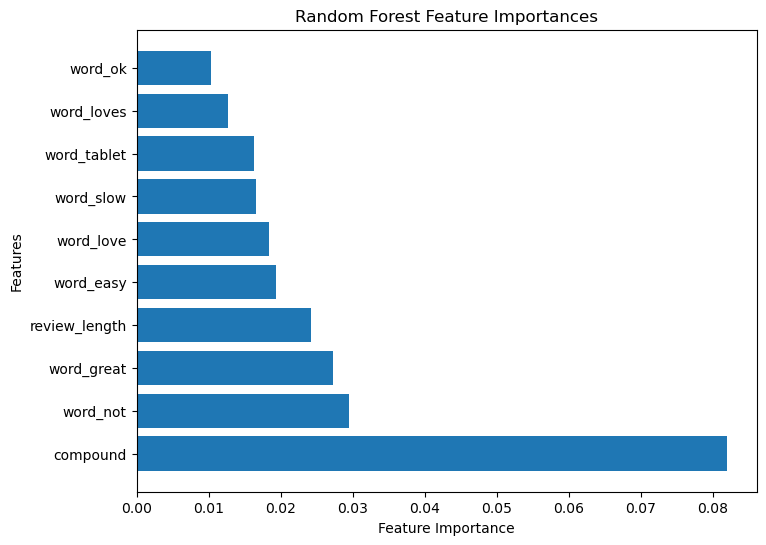

In [84]:
plt.figure(figsize=(8, 6))
plt.barh(feature_importances_df.loc[:9,"feature"], feature_importances_df.loc[:9,"importance"])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importances')
plt.show()

## Logistic Regression

In [85]:
# Fitting logistic regression model on training data
log_reg = sm.Logit(y_train, x_train).fit()

Optimization terminated successfully.
         Current function value: 0.451366
         Iterations 8


In [86]:
print(log_reg.summary()) 

                            Logit Regression Results                           
Dep. Variable:     reviews.doRecommend   No. Observations:                 1125
Model:                           Logit   Df Residuals:                     1115
Method:                            MLE   Df Model:                            9
Date:                 Sat, 29 Jun 2024   Pseudo R-squ.:                  0.3488
Time:                         09:22:58   Log-Likelihood:                -507.79
converged:                        True   LL-Null:                       -779.77
Covariance Type:             nonrobust   LLR p-value:                2.191e-111
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
compound          1.7272      0.185      9.350      0.000       1.365       2.089
word_not        -12.9096      2.806     -4.601      0.000     -18.409      -7.410
word_great        6.7229      2.

## Naive Bayes

In [84]:
# Fitting Bernoulli Naive Bayes classifier model on training data to make predictions on test data
nb_classifier = BernoulliNB()
nb_classifier.fit(x_train, y_train)
nb_preds = nb_classifier.predict(x_test)
nb_accuracy = accuracy_score(y_test, nb_preds) * 100
print(f"Accuracy of Bernoulli Naive Bayes Model: {nb_accuracy:.2f}%")

print(classification_report(y_test, nb_preds))

Accuracy of Bernoulli Naive Bayes Model: 76.19%
              precision    recall  f1-score   support

           0       0.81      0.64      0.72        59
           1       0.73      0.87      0.79        67

    accuracy                           0.76       126
   macro avg       0.77      0.75      0.76       126
weighted avg       0.77      0.76      0.76       126



## Decision Tree

In [87]:
# Fitting Decision Tree model on training data to make predictions on test data
np.random.seed(42)
dt_classifier = DecisionTreeClassifier(random_state=42, max_depth = 3)
dt_classifier.fit(x_train, y_train)

dt_preds = dt_classifier.predict(x_test)
accuracy = accuracy_score(y_test, dt_preds)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.73
              precision    recall  f1-score   support

           0       0.85      0.76      0.80        59
           1       0.81      0.88      0.84        67

    accuracy                           0.83       126
   macro avg       0.83      0.82      0.82       126
weighted avg       0.83      0.83      0.82       126



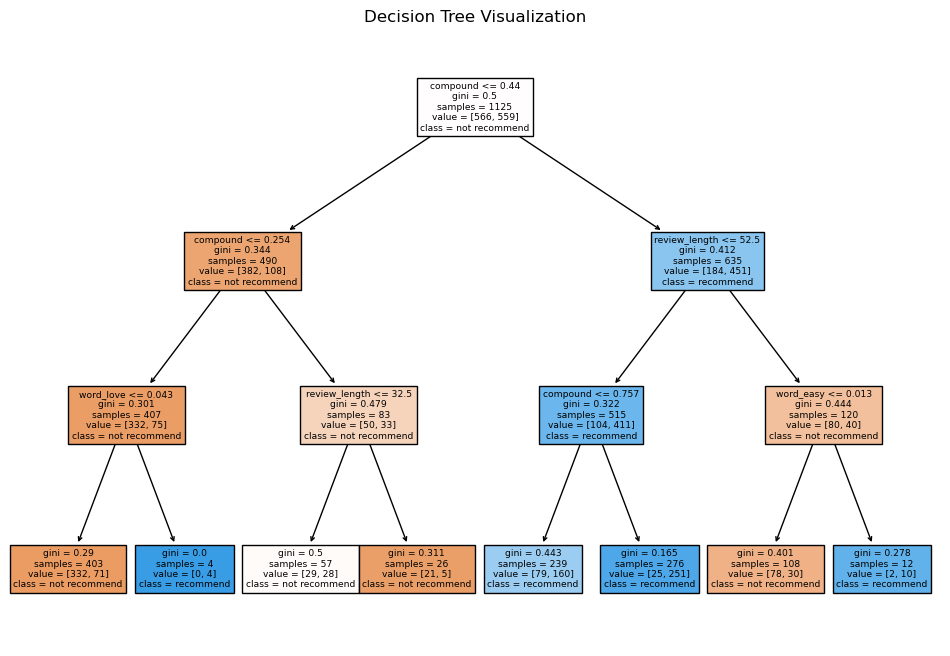

In [88]:
feature_names_list = list(x_train.columns)
plt.figure(figsize=(12, 8))
plot_tree(dt_classifier, feature_names=feature_names_list, class_names=['not recommend', 'recommend'], filled=True)
plt.title("Decision Tree Visualization")
plt.show()